<a href="https://colab.research.google.com/github/mahyarhabibi/GenderGaps_Hollywood/blob/main/Codes/critics_favoritism_pub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook estimate the regression model specified in Equation (5) in the paper to obtain estimates of critics' biases at the individual level.

In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm
from patsy import dmatrices
from statsmodels.iolib.summary2 import summary_col
import re
import os

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Directories to read data and store results
#Please add the parent folder to your Google Drive
# Public Link: https://drive.google.com/drive/folders/1TYCDAJOCiLZw4TObcLac5GnL5YtwYnUD?usp=sharing
parent_dir = "/content/gdrive/MyDrive/GenderGaps_Hollywood/" # You may need to change the address
data_dir = os.path.join(parent_dir, 'Data/')
results_dir = os.path.join(parent_dir,'Results/')

In [ ]:
# Loading Data and Predicted scores
df_movies = pd.read_pickle(data_dir + 'movies_info_merged_MIW_pkl.zip')

#Reviews
df_crevs = pd.read_pickle(data_dir + 'reviews_critics_merged.zip')
crev_cols = ['Title', 'Year', 'title_year' ,'source', 'author', 'score','C_count', 
             'R_count', 'C_Female', 'C_start', 'C_end', 'C_avg','C_exper']
df_crevs = df_crevs[crev_cols]

In [ ]:
# Creating a list of genres
genres = set(df_movies['genre'].sum())
for gen in genres:
    df_movies[gen] = df_movies['genre'].map(lambda x: 1 if gen in x else 0)
    
df_movies = df_movies.rename(columns={'Film-Noir': 'FilmNoir', 'Sci-Fi': 
                                      'SciFi', 'Reality-TV': 'RealityTV',
                                      'Talk-Show': 'TalkShow'})

genres = genres - {'Film-Noir','Sci-Fi','Reality-TV', 'Talk-Show'}
genres = list(genres.union({'FilmNoir','SciFi','RealityTV', 'TalkShow'}))

In [ ]:
# Plots' Truncated SVD Vectors
plot_vectors = [f'plot_vec{i}' for i in range(100)]
X_vecs = df_movies[plot_vectors]

In [ ]:
#Cast
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

X_cast = pd.DataFrame(mlb.fit_transform(df_movies['cast']),columns=mlb.classes_, index=df_movies.index)

# Keeping actors whose names showed up at least 5 times
X_cast = X_cast[X_cast.columns[X_cast.sum()>=10]]

In [ ]:
# Companies with at least 10 movies
X_company = pd.get_dummies(df_movies['company'])
X_company = X_company[X_company.columns[X_company.sum()>=10]]

# Distributors with at least 10 movies
X_dist = pd.get_dummies(df_movies['Distributor'])
X_dist = X_dist[X_dist.columns[X_dist.sum()>=10]]

In [ ]:
#Countries
df_movies['country_list'] = df_movies['country'].map(lambda x: re.sub(' ','',x)).\
                        map(lambda x: x.split(','))

X_country = pd.DataFrame(mlb.fit_transform(df_movies['country_list']),
             columns=mlb.classes_, index=df_movies.index)

X_country = X_country[X_country.columns[X_country.sum()>=10]]

#Language
df_movies['lang_list'] = df_movies['language'].map(lambda x: re.sub(' ','',x)).\
                        map(lambda x: x.split(','))
X_lang = pd.DataFrame(mlb.fit_transform(df_movies['lang_list']),
             columns=mlb.classes_, index=df_movies.index)
X_lang = X_lang[X_lang.columns[X_lang.sum()>=10]]


# Age Ratings Categories
X_mpaa = df_movies[['rated_R','rated_PG', 'rated_PG13', 'rated_TVMA', 'rated_TV14']]

# Genres
X_genre = df_movies[genres]

In [ ]:
# Merging Features
X_mov = df_movies[['Title', 'Year', 'D_Female']].join(X_vecs).join(X_cast, rsuffix='cs').\
  join(X_company, rsuffix='cp').join(X_dist, rsuffix='ds').\
  join(X_country, rsuffix='cn').join(X_lang, rsuffix='lg').\
        join(X_mpaa).join(X_genre, rsuffix='gn')


X_score = df_crevs[['Title', 'Year', 'score', 'title_year']].\
      merge(X_mov, on=['Title', 'Year']).drop(columns=['Title'])

  
X_score['TY_code'] = X_score['title_year'].factorize()[0]
X_score = X_score.drop(columns=['title_year'])
X_source = pd.get_dummies(df_crevs['source'])

#Critics with more than 50 reviews
X_author = pd.get_dummies(df_crevs['author'])
X_author = X_author[X_author.columns[X_author.sum()>=100]]

X_year = pd.get_dummies(df_crevs['Year'])

In [ ]:
# Creating/loading a file for storing the results
import os.path
import json
if os.path.exists(results_dir + 'critics_reg_results.json'):
  with open(results_dir + 'critics_reg_results.json', 'r') as input_file:
    critics_reg_results = json.load(input_file)
else:
  critics_reg_results = {}

In [ ]:
def reviews_reg_sum(reg_res,target_vars,target_locs):
  results_sum = { 'main vars':target_vars, 
                 'coefs': [reg_res.params[x] for x in target_vars],
                'std_errors': [reg_res.bse[x] for x in target_vars],
                't_values': [reg_res.tvalues[x] for x in target_vars],
                 'p_values': [reg_res.pvalues[x] for x in target_vars],
                'conf_intervals': [ list(reg_res.conf_int().values[i]) for i in target_locs],
                 'R_squared': reg_res.rsquared, 'adj R_squared': reg_res.rsquared_adj, 'N_Obs': reg_res.nobs}

  return results_sum

# Matrix Factorization: Estimating Authors' Discrimination

In [ ]:
# Loading preference scores
df_preds = pd.read_pickle(data_dir + 'critic_predicted_scores.pkl')
df_preds = df_preds.rename(columns= {'Author': 'author'})

In [ ]:
# Merge with movie-characteristics dataset
df_cpreds = df_crevs.merge(df_preds[['title_year', 'author', 'predicted_score']],
                          on=['title_year', 'author'], how='left')

In [ ]:
# # Construct Data Matrices

X_pscore = X_score.join(df_cpreds['predicted_score'])
# Author * D_Female 
arr_author = X_author.to_numpy()
arr_DFem = X_pscore['D_Female'].to_numpy()
author_DFem = arr_author * arr_DFem[:,None]


author_DFem_cols = ['DFem_x_' + str(name) for name in X_author.columns.values]
X_author_DFem = pd.DataFrame(author_DFem, columns=author_DFem_cols,
                             index=X_pscore.index.values)


data_ols = X_pscore.join(X_year).join(X_source,rsuffix='src_').\
            join(X_author, lsuffix='mv').join(X_author_DFem).dropna() 


y_ols = data_ols['score']
X_ols = data_ols.drop(columns=['score'])
TY = X_ols['TY_code'].values.astype(int)
X_ols = X_ols.drop(columns=['TY_code'])


In [ ]:
# Estimating critics personal favoritism controlling preference scores

reg_ols = sm.OLS(y_ols, X_ols) 
res_ols = reg_ols.fit(cov_type='cluster', cov_kwds={'groups': TY })

# Identifying Authors in the covariates
all_authors = set(X_author.columns.values)
all_cols = set(X_ols.columns.values)
authors = list(all_authors.intersection(all_cols))
target_vars = ['D_Female', 'predicted_score'] + author_DFem_cols 
target_locs = [X_ols.columns.get_loc(var) for var in target_vars]

ols_res_sum = reviews_reg_sum(res_ols,target_vars, target_locs)
critics_reg_results.update( {'critics_indiv_bias_with_pred_score':ols_res_sum })

with open(results_dir + 'critics_reg_results.json', 'w') as outfile:
    json.dump(critics_reg_results, outfile)

In [ ]:
# Without Controlling For preference Scores

X_ols = X_ols.drop(columns = ['predicted_score'])

reg_ols = sm.OLS(y_ols, X_ols) 
res_ols = reg_ols.fit(cov_type='cluster', cov_kwds={'groups': TY })

target_vars = ['D_Female'] + author_DFem_cols 
target_locs = [X_ols.columns.get_loc(var) for var in target_vars]

ols_res_sum = reviews_reg_sum(res_ols,target_vars, target_locs)
critics_reg_results.update( {'critics_indiv_bias_wo_pred_score':ols_res_sum })

with open(results_dir + 'critics_reg_results.json', 'w') as outfile:
    json.dump(critics_reg_results, outfile)


In [ ]:
# Stroing the results when pred scores are included
var_authors_wt_pred = critics_reg_results['critics_indiv_bias_with_pred_score']\
                      ['main vars'][2:]
tval_authors_wt_pred = critics_reg_results['critics_indiv_bias_with_pred_score']\
                      ['t_values'][2:]
pval_authors_wt_pred = critics_reg_results['critics_indiv_bias_with_pred_score']\
                      ['p_values'][2:]
coef_authors_wt_pred = critics_reg_results['critics_indiv_bias_with_pred_score']\
                      ['coefs'][2:]
df_authors_disc_wt_pred = pd.DataFrame(data={'author': var_authors_wt_pred, 
                                             'coef': coef_authors_wt_pred,
                                    't-value': tval_authors_wt_pred, 
                                    'p-value': pval_authors_wt_pred})

df_authors_disc_wt_pred = df_authors_disc_wt_pred.loc[np.abs(df_authors_disc_wt_pred['coef'])>1e-10]

In [ ]:
# Stroing the results when pred scores are not included
var_authors_wo_pred = critics_reg_results['critics_indiv_bias_wo_pred_score']\
                      ['main vars'][2:]
tval_authors_wo_pred = critics_reg_results['critics_indiv_bias_wo_pred_score']\
                      ['t_values'][2:]
pval_authors_wo_pred = critics_reg_results['critics_indiv_bias_wo_pred_score']\
                      ['p_values'][2:]
coef_authors_wo_pred = critics_reg_results['critics_indiv_bias_wo_pred_score']\
                      ['coefs'][2:]
df_authors_disc_wo_pred = pd.DataFrame(data={'author': var_authors_wo_pred, 
                                             'coef': coef_authors_wo_pred,
                                    't-value': tval_authors_wo_pred, 
                                    'p-value': pval_authors_wo_pred})

df_authors_disc_wt_pred = df_authors_disc_wt_pred.loc[np.abs(df_authors_disc_wt_pred['coef'])>1e-10]

In [ ]:
df_authors_disc = df_authors_disc_wt_pred.merge(df_authors_disc_wo_pred, 
                                   on='author', suffixes = (None, '_wo_pred'))

In [ ]:
df_authors_disc[['coef', 'coef_wo_pred']].describe()

,coef,coef_wo_pred
count,371.000000,371.000000
mean,0.000531,-0.006499
std,4.044187,4.808788
min,-14.658948,-17.139727
25%,-2.282568,-2.989808
50%,-0.012975,-0.002692
75%,2.245786,2.695864
max,15.898811,18.377507


Text(0.5, 0, ' Est. Coefficient of Dicrimination (pp)')

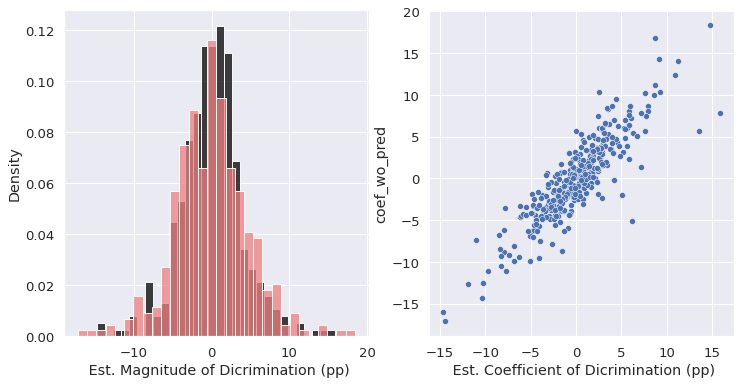

In [ ]:
# Figure
sns.set(font_scale=1.2)
fig, axes = plt.subplots(1,2, figsize=(12,6))
sns.histplot(ax= axes[0], x=df_authors_disc['coef'], stat='density', color = 'black', bins=30)
sns.histplot(ax= axes[0], x=df_authors_disc['coef_wo_pred'], stat='density', color='lightcoral', bins=30)

sns.scatterplot(ax= axes[1], x=df_authors_disc['coef'], 
                y=df_authors_disc['coef_wo_pred'])
# sns.scatterplot(ax= axes[1], x=df_authors_disc_wo_pred['coef'], 
#                 y=df_authors_disc_wo_pred['t-value'])

axes[0].set_xlabel(' Est. Magnitude of Dicrimination (pp)')
axes[1].set_xlabel(' Est. Coefficient of Dicrimination (pp)')

In [ ]:
# Benjamini-Hochberg False Discovery Rate_ with predictions
df_authors_sorted = df_authors_disc.sort_values(by='p-value', ignore_index=True)
CDpval_sorted = df_authors_sorted['p-value']
n_C = len(CDpval_sorted)
q = 0.1

# Benjamini-Hochberg FDR Control
C_reject = [[df_authors_sorted['author'][idx], df_authors_sorted['coef'][idx], 
             pval] for idx, pval in enumerate(CDpval_sorted) if pval <= (idx+1)*q/n_C]

print(f'Total Number of Authors: {len(df_authors_sorted)}')

print(f'Number of Biased Authors: {len(C_reject)}')

Total Number of Authors: 371
Number of Biased Authors: 13


In [ ]:
# Benjamini-Hochberg False Discovery Rate_ without predictions
df_authors_sorted_wop = df_authors_disc.sort_values(by='p-value_wo_pred', ignore_index=True)
CDpval_sorted_wop = df_authors_sorted['p-value_wo_pred']
n_C_wop = len(CDpval_sorted_wop)
q = 0.1

# Benjamini-Hochberg FDR Control
C_reject_wop = [[df_authors_sorted['author'][idx], df_authors_sorted['coef_wo_pred'][idx], 
             pval] for idx, pval in enumerate(CDpval_sorted_wop) if pval <= (idx+1)*q/n_C_wop]

print(f'Total Number of Authors: {len(df_authors_sorted)}')

print(f'Number of Biased Authors: {len(C_reject_wop)}')

Total Number of Authors: 371
Number of Biased Authors: 39
